# PlantVillage Dataset
### Este dataset contiene imágenes de hojas de plantas y su estado de salud (sana o enferma + tipo de enfermedad).

**Objetivo**: Dada una imagen de una hoja, clasificarla en una clase (especie de planta + estado de salud (ej., 'Tomato___Late_blight', 'Tomato___healthy).

Importamos las librerías de análisis de datos (numpy, pandas), visualización (matplotlib, seaborn), procesamiento de imágenes (PIL) y modelos (keras).



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

Importamos el dataset de Kaggle y analizamos una de las carpetas para ver cuántas clases hay para la clasificación y mostramos algunos ejemplos de estas clases.

In [ ]:
import kagglehub
datasource_path_completo = kagglehub.dataset_download('abdallahalidev/plantvillage-dataset')

print('Se completó la descarga del Data Source en: ', datasource_path_completo)

Se completó la descarga del Data Source en:  /kaggle/input/plantvillage-dataset


In [ ]:
dataset_path = datasource_path_completo + '/plantvillage dataset/color'
classes = os.listdir(dataset_path)
num_classes = len(classes)

print(f"Número de clases: {num_classes}")
print("Ejemplo de clases:", classes[:5])  # Primeras 5 clases

Número de clases: 38
Ejemplo de clases: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']


Contamos la cantidad de imágenes por clase y graficamos (para detectar posibles desbalances).

<ipython-input-5-d485b083a9d6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_counts.index, y=df_counts['Count'], palette="viridis")


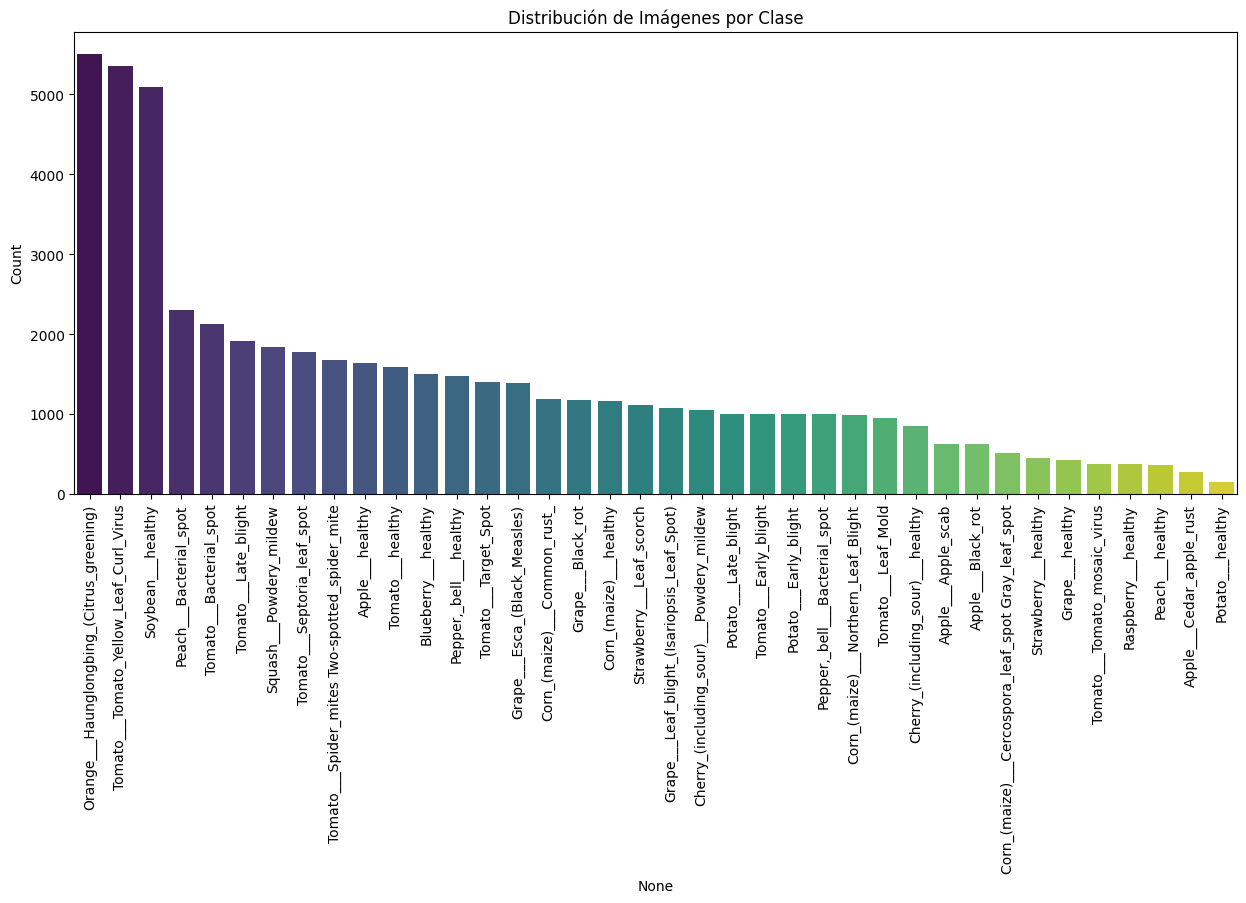

In [ ]:
class_counts = {}
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Convertir a DataFrame para gráficos
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df_counts.sort_values(by='Count', ascending=False, inplace=True)

# Gráfico de barras
plt.figure(figsize=(15, 6))
sns.barplot(x=df_counts.index, y=df_counts['Count'], palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribución de Imágenes por Clase")
plt.show()

## Preprocesamiento:
*   Redimensionamos imágenes a un tamaño fijo (256x256 píxeles).
*   Aplicamos data augmentation: transformamos imágenes de forma aleatoria para generar más variedad y evitar sobreajuste.
*   Se reserva el 20% de las imágenes para validación.
*   Creamos los generadores.

In [ ]:
# Parámetros
IMG_SIZE = (256, 256)  # Reducimos resolución para acelerar entrenamiento
BATCH_SIZE = 32

# Generador para entrenamiento (con augmentación)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% para validación
)

path_de_trabajo = dataset_path
# Generadores
train_generator = train_datagen.flow_from_directory(
    path_de_trabajo,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    path_de_trabajo,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


Creamos una **red convolucional** básica con 3 capas Conv2D seguidas de MaxPooling2D.

Luego una capa Dense (512 neuronas), Dropout para regularización, y Dense final para clasificación (softmax para multiclase).

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # num_classes definido por flow_from_directory
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,095,654 (225.43 MB)

 Trainable params: 59,095,654 (225.43 MB)

 Non-trainable params: 0 (0.00 B)

**EarlyStopping** detiene el entrenamiento si la pérdida de validación no mejora durante 3 épocas seguidas.

Entrenamos el modelo hasta 30 épocas, pero puede cortarse antes.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 949s 693ms/step - accuracy: 0.4050 - loss: 2.2132 - val_accuracy: 0.7191 - val_loss: 0.8847
Epoch 2/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 769s 566ms/step - accuracy: 0.7072 - loss: 0.9699 - val_accuracy: 0.8292 - val_loss: 0.5417
Epoch 3/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 781s 576ms/step - accuracy: 0.7756 - loss: 0.7219 - val_accuracy: 0.8566 - val_loss: 0.4532
Epoch 4/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 771s 568ms/step - accuracy: 0.8139 - loss: 0.6025 - val_accuracy: 0.8412 - val_loss: 0.5008
Epoch 5/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 769s 567ms/step - accuracy: 0.8262 - loss: 0.5563 - val_accuracy: 0.8964 - val_loss: 0.3217
Epoch 6/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 768s 565ms/step - accuracy: 0.8433 - loss: 0.4919 - val_accuracy: 0.9000 - val_loss: 0.3076
Epoch 7/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 763s 562ms/step - accuracy: 0.8569 - loss: 0.4570 - val_accuracy: 0.9030 - val_loss: 0.3005
Epoch 8/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 765s 563ms/step - ac

# Evaluación

Curvas de precisión y pérdida para entrenamiento y validación.

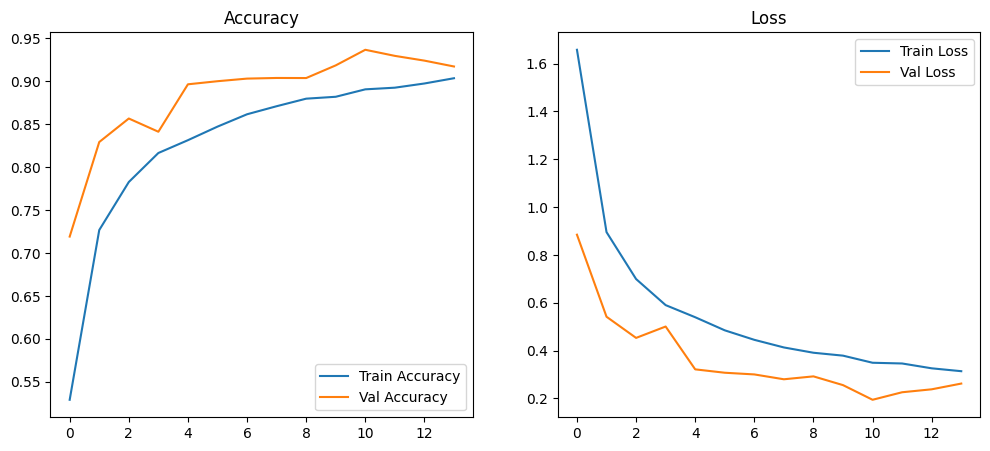

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

Generamos las predicciones del modelo sobre el conjunto de validación y mostramos la matríz de confusión (permite ver cuántos aciertos y errores hubo por clase).

340/340 ━━━━━━━━━━━━━━━━━━━━ 155s 455ms/step


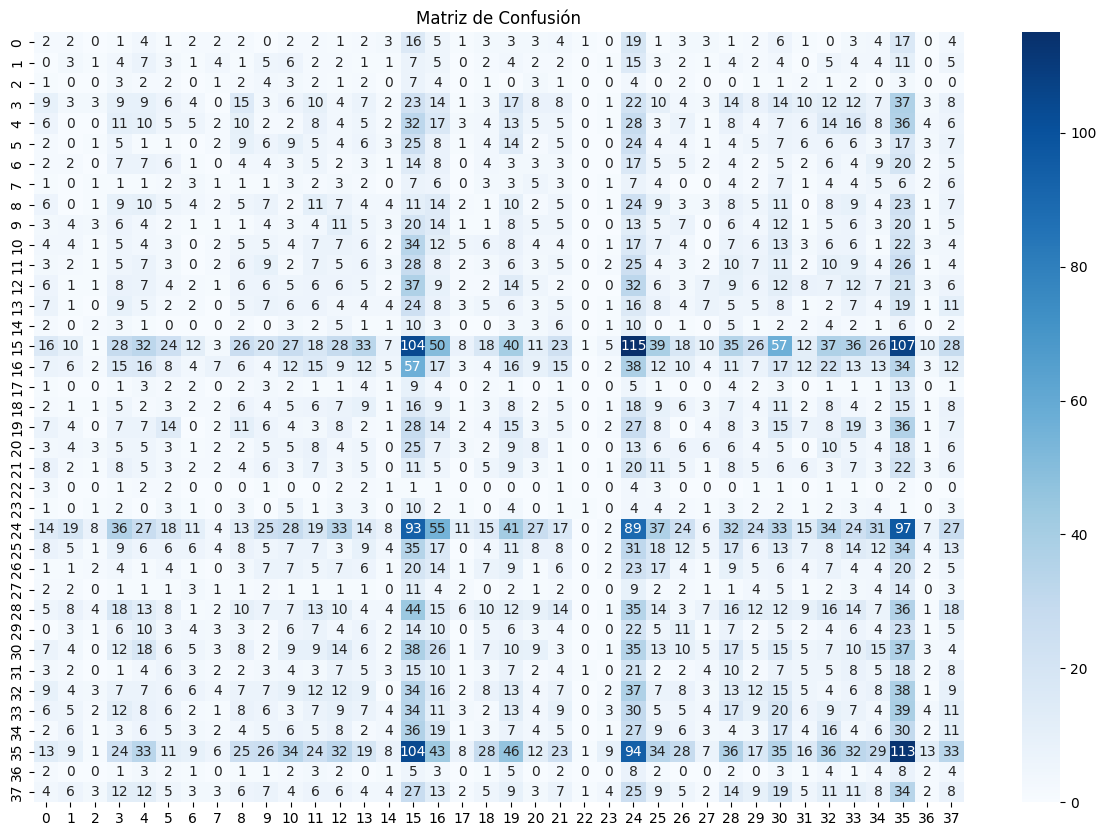

In [ ]:
# Predecir en validation set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1) # Aquí obtenemos las clases predichas (índice del valor más alto de softmax).
y_true = val_generator.classes

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

Mostramos el reporte detallado:

Precisión: TP / (TP + FP)

Recall: TP / (TP + FN)

F1-score: balance entre precisión y recall

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=classes))

                                                    precision    recall  f1-score   support

                              Tomato___Late_blight       0.01      0.02      0.01       126
                                  Tomato___healthy       0.02      0.02      0.02       124
                                   Grape___healthy       0.00      0.00      0.00        55
          Orange___Haunglongbing_(Citrus_greening)       0.03      0.03      0.03       329
                                 Soybean___healthy       0.03      0.03      0.03       300
                           Squash___Powdery_mildew       0.01      0.00      0.00       210
                                  Potato___healthy       0.01      0.01      0.01       170
               Corn_(maize)___Northern_Leaf_Blight       0.01      0.01      0.01       102
                             Tomato___Early_blight       0.02      0.02      0.02       238
                       Tomato___Septoria_leaf_spot       0.02      0.02      0.